# Project- Kosterlitz-Thouless Transition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 10
from scipy.stats import linregress
from scipy.optimize import curve_fit
from tqdm import tqdm
from glob import glob

# Defining the monte-carlo sweeps

In [2]:
@njit
def mc_sweep(spin_lat, energy, L, J, T):

    '''
    Performs a single Monte-Carlo sweep over the lattice, consisting of N trial changes to random spins.

    Parameters:
    -----------
    • spin_lat : A 2D array of all the spins in the lattice, with each spin represented by an angle between 0 and 2*pi.
    • energy : The initial energy of the lattice.
    • L : The number of spins along one dimension of the lattice (spin_lat will be an LxL array).
    • J : The interaction energy parameter.
    • T : The temperature at which the system is being simulated.

    Returns:
    --------
    • spin_lat : The array of spins after the Monte-Carlo sweep is completed.
    • energy : The energy of the system after the Monte-Carlo sweep is completed.

    '''

    N = L**2      # Defining the number of spins, assuming a square lattice.

    for x in range(N):    # Doing N trial changes, so on average every spin is flipped once in a sweep.
        i = int(L*np.random.uniform(0,1))    # Choosing a random spin
        j = int(L*np.random.uniform(0,1))
        old_spin = spin_lat[i][j]
        a = np.cos(old_spin - spin_lat[(i-1)%L][j])     # Calculating the initial energy for this site, by getting the contribution from each nearest neighbour
        b = np.cos(old_spin - spin_lat[(i+1)%L][j])     # Nearest neighbours are calculated with boundary conditions.
        c = np.cos(old_spin - spin_lat[i][(j-1)%L])
        d = np.cos(old_spin - spin_lat[i][(j+1)%L])
        E_old = -J*(a+b+c+d)

        test_spin = (old_spin + np.random.uniform(0,1)*2*np.pi)%(2*np.pi)     # adding a random angle between 0 and 2*pi
        # test_spin = np.random.uniform(0,1)*2*np.pi

        a = np.cos(test_spin - spin_lat[(i-1)%L][j])     # Calculating the new energy with the trial change.
        b = np.cos(test_spin - spin_lat[(i+1)%L][j])
        c = np.cos(test_spin - spin_lat[i][(j-1)%L])
        d = np.cos(test_spin - spin_lat[i][(j+1)%L])
        E_trial = -J*(a+b+c+d)
        dE = E_trial - E_old      # Calculating the change in energy


        if dE<=0:       # if energy is reduced, automatically accept.
            spin_lat[i][j] = test_spin      # Change energy and spin
            energy += dE
        else:       # if energy is increased, accept with Boltzmann weighted probability
            r = np.random.uniform(0,1)
            w = np.exp(-dE/T)
            if r<=w:
                spin_lat[i][j] = test_spin     # Change energy and spin
                energy += dE

    return spin_lat, energy

In [3]:
@njit
def mc_run(L=32, J=1, T=3, N_runs=100):

    '''
    Simulates an XY model of spins on a lattice using many Monte-Carlo sweeps, at a given temperature.

    Parameters:
    -----------
    • L : The number of spins along one dimension of the lattice.
    • J : The interaction energy parameter.
    • T : The temperature at which the system is being simulated.
    • N_runs : The number of Monte-Carlo sweeps to be performed on the lattice.

    Returns:
    --------
    • spin_lat_0 : The initial array of spins created before running the Monte-Carlo sweeps.
    • spin_lat : The array of spins after the Monte-Carlo sweeps are completed.
    • E : A 1D array of length = N_runs, containing the energy of the system after each Monte-Carlo sweep.
    • M : A 2D array of size (N_runs x 2), containing the magnetization of the system in the x- and y-directions after each Monte-Carlo sweep.

    '''

    E = np.zeros(N_runs)    # Initialize energy array
    M = np.zeros((N_runs,2), dtype=np.float64)    # Initialize magnetization array

    # Setup initial lattice
    spin_lat_0 = np.ones((L, L))
    for i in range(L):
        for j in range(L):
            spin_lat_0[i][j] *= np.random.uniform(0,1)*2*np.pi     # Choose random spins for each site.

    E_0 = 0
    M_0 = np.array([0,0], dtype=np.float64)
    for i in range(L):
        for j in range(L):
            a = np.cos(spin_lat_0[i][j] - spin_lat_0[(i-1)%L][j])    # Calculate contribution from each nearest neighbour
            b = np.cos(spin_lat_0[i][j] - spin_lat_0[(i+1)%L][j])
            c = np.cos(spin_lat_0[i][j] - spin_lat_0[i][(j-1)%L])
            d = np.cos(spin_lat_0[i][j] - spin_lat_0[i][(j+1)%L])
            E_0 += -J*(a+b+c+d)/2     # Calculate initial energy
            M_0[0] += np.cos(spin_lat_0[i][j])      # Calculate initial magnetization in each direction.
            M_0[1] += np.sin(spin_lat_0[i][j])


    spin_lat = np.copy(spin_lat_0)    # Create copy so that initial array is preserved.
    E[0] = E_0
    M[0] = M_0

    # Start monte-carlo sweeps
    for k in range(1,N_runs):
        spin_lat, E[k] = mc_sweep(spin_lat=spin_lat, energy=E[k-1], L=L, J=J, T=T)     # Perform Monte-Carlo sweep, add energy to the energy array
        M[k,0] = np.sum(np.cos(spin_lat))      # Calculate and append magnetization values.
        M[k,1] = np.sum(np.sin(spin_lat))

    return spin_lat_0, spin_lat, E, M    # return initial array, final array, energy and magnetization

In [4]:
@njit
def id_vortex(spins):

    '''
    Detects vortices in a lattice of spins.

    Parameters:
    -----------
    • spins : A 2D array of all the spins in the lattice, wuth each spin represented by an angle between 0 and 2*pi.

    Returns:
    --------
    • vortices : A 2D array of size (nv x 2) containing the (x,y) coordinates of each vortex found in the system.
    • antivortices : A 2D array of size (nav x 2) containing the (x,y) coordinates of each anti-vortex found in the system.
    • nv : The number of vortexes found.
    • nav : The number of anti-vortexes found.

    '''

    x,y = np.shape(spins)    # Getting the dimensions of the array.
    L = x
    vortices = np.array([[0,0],[0,0]], dtype=np.float64)      # Initialize coordinates array for vortices. Two set of 'junk' coordinates are added to correctly set the dimnesions of the array.
    antivortices = np.array([[L-1,L-1],[L-1,L-1]], dtype=np.float64)      # Similarly initialize coordinates array for anti-vortices.

    for i in range(x):     # Iterate over each spin in the lattice
        for j in range(y):

            # Go over the plaquette of spins associated with it, and calculate each difference in angle (in anti-clockwise order)
            a = (spins[i][(j+1)%L] - spins[i][j])
            b = (spins[(i+1)%L][(j+1)%L] - spins[i][(j+1)%L])
            c = (spins[(i+1)%L][j] - spins[(i+1)%L][(j+1)%L])
            d = (spins[i][j] - spins[(i+1)%L][j])

            product = a*b*c*d      # Get product of differences
            sum_ = abs(a % np.pi)+abs(b % np.pi)+abs(c % np.pi)+abs(d % np.pi)      # Get sum of differences

            if (product<0 and sum_==2*np.pi):  # Vortex found
                arr = np.array([a,b,c,d])
                arr.sort()    # Sort the array of differences into ascending order, to check vortex vs. antivortex.

                if arr[1]>0:    # Vortices will have 1 negative difference, so the second element should be positive.
                    coord = np.array([[j+0.5,i+0.5]])
                    vortices = np.append(vortices, coord, axis=0)      # Add coordinates of vortex to array
                elif arr[1]<0:    # Anti-vortices will have 1 positive difference, so the second element should be negative.
                    coord = np.array([[j+0.5,i+0.5]])
                    antivortices = np.append(antivortices, coord, axis=0)      # Add coordinates of antivortex to array

    nv = len(vortices) - 2    # Number of vortices (subtracting two 'junk' entries)
    nav = len(antivortices) - 2    # Number of antivortices (subtracting two 'junk' entries)
    return vortices[2:], antivortices[2:], nv, nav     # return coordinate arrays (without junk entries) and numbers of each kind.

In [5]:
@njit
def mc_run_alt(spin_lat_0, J=1, T=3, N_runs=100):

    '''
    Alternate version of the mc_run() function, with two modifications- it takes in a specified lattice as the input for the starting configuration,
    and it outputs number of vortices and antivortices at every run.
    Simulates an XY model of spins on a lattice using many Monte-Carlo sweeps, at a given temperature.

    Parameters:
    -----------
    • spin_lat_0 : The initial lattice configuration (A 2D array of all the spins in the lattice, with each spin represented by an angle between 0 and 2*pi).
    • J : The interaction energy parameter.
    • T : The temperature at which the system is being simulated.
    • N_runs : The number of Monte-Carlo sweeps to be performed on the lattice.

    Returns:
    --------
    • spin_lat : The array of spins after the Monte-Carlo sweeps are completed.
    • E : A 1D array of length = N_runs, containing the energy of the system after each Monte-Carlo sweep.
    • M : A 2D array of size (N_runs x 2), containing the magnetization of the system in the x- and y-directions after each Monte-Carlo sweep.
    • V : A 1D array of length = N_runs, containing the number of vortices and antivortices found in the system after each Monte-Carlo sweep.
    • V_f : A 1D array of length = N_runs, containing the (absolute) difference in the number of vortices and antivortices found in the system after each Monte-Carlo sweep.

    '''

    L = np.shape(spin_lat_0)[0]
    E = np.zeros(N_runs)    # Initialize energy array
    M = np.zeros((N_runs,2), dtype=np.float64)    # Initialize magnetization array
    V = np.zeros(N_runs)    # Initialize vortices array
    V_f = np.zeros(N_runs)    # Initialize free vortices array

    E_0 = 0
    M_0 = np.array([0,0], dtype=np.float64)
    nv = 0; nav = 0

    # Calculating initial energy and magnetization
    for i in range(L):
        for j in range(L):
            a = np.cos(spin_lat_0[i][j] - spin_lat_0[(i-1)%L][j])
            b = np.cos(spin_lat_0[i][j] - spin_lat_0[(i+1)%L][j])
            c = np.cos(spin_lat_0[i][j] - spin_lat_0[i][(j-1)%L])
            d = np.cos(spin_lat_0[i][j] - spin_lat_0[i][(j+1)%L])
            E_0 += -J*(a+b+c+d)/2
            M_0[0] += np.cos(spin_lat_0[i][j])
            M_0[1] += np.sin(spin_lat_0[i][j])

    v, av, nv, nav = id_vortex(spin_lat_0)      # Getting the number of vortices and antivortices initially
    spin_lat = np.copy(spin_lat_0)      # Create copy so that initial array is preserved.
    E[0] = E_0
    M[0] = M_0
    V[0] = nv+nav     # Number of vortices and anti-vortices total
    V_f[0] = abs(nv-nav)    # Number of free vortices

    # Start monte-carlo sweeps
    for k in range(1,N_runs):
        spin_lat, E[k] = mc_sweep(spin_lat=spin_lat, energy=E[k-1], L=L, J=J, T=T)     # Perform Monte-Carlo sweep, add energy to the energy array
        M[k,0] = np.sum(np.cos(spin_lat))       # Calculate and append magnetization values.
        M[k,1] = np.sum(np.sin(spin_lat))
        v, av, nv, nav = id_vortex(spin_lat)        # Calculate and append values of no. of vortices and no. of free vortices.
        V[k] = nv+nav
        V_f[k] = abs(nv-nav)

    return spin_lat, E, M, V, V_f

In [6]:
def E_per_spin(spin_lat_0):

    '''
    Gets the energy of each site on the lattice of spins.

    Parameters:
    -----------
    • spin_lat_0 : A 2D array of all the spins in the lattice, with each spin represented by an angle between 0 and 2*pi.

    Returns:
    --------
    • E_lat : A 2D array of the same dimensions as spin_lat_0, containing the energy per site of the spin system.

    '''

    L = np.shape(spin_lat_0)[0]
    E_lat = np.zeros_like(spin_lat_0)
    for i in range(L):
        for j in range(L):
            a = np.cos(spin_lat_0[i][j] - spin_lat_0[(i-1)%L][j])
            b = np.cos(spin_lat_0[i][j] - spin_lat_0[(i+1)%L][j])
            c = np.cos(spin_lat_0[i][j] - spin_lat_0[i][(j-1)%L])
            d = np.cos(spin_lat_0[i][j] - spin_lat_0[i][(j+1)%L])
            E_lat[i][j] = -(a+b+c+d)/2
    return E_lat

In [7]:
def animate(spins, T, h=0, step=1, save_animation=False, save_name='video.mp4', save_dpi=300, save_fps=100):
    '''
    Animation of the spin system. This is useful to observe the movement and evolution of vortices and antivortices on the lattice.
    '''

    width = 3
    fig, axes = plt.subplots(figsize=(width,width))

    def plotsetup():
        axes.set_aspect('equal'); axes.tick_params(top=False, bottom=False, left=False, right=False,
                                                       labelleft=False, labelbottom=False)

        plt.tight_layout()

    ############################################################################################

    L = len(spins); N = L**2; J=1; # Parameters of the simulation


    initialEnergy = 0; initialM = 0

    for i in range(L):
        for j in range(L):
            a = np.cos(spins[i][j] - spins[(i-1)%L][j])
            b = np.cos(spins[i][j] - spins[(i+1)%L][j])
            c = np.cos(spins[i][j] - spins[i][(j-1)%L])
            d = np.cos(spins[i][j] - spins[i][(j+1)%L])
            initialEnergy += -J*(a+b+c+d)/2
            initialM += spins[i][j]

    initialV, initialAV, nv, nav = id_vortex(spins)
    v_num = len(initialV) + len(initialAV)
    energy = E_per_spin(spins)

    mdata = []; edata = []; vdata = []; avdata = []; v_avg = []; framedata = []; spinHistory = []; energyHistory = []
    mdata.append(initialM); edata.append(initialEnergy/N); vdata.append(np.array(initialV)); avdata.append(np.array(initialAV)); v_avg.append(v_num)
    framedata.append(0*step); spinHistory.append(spins); energyHistory.append(energy)
    ############################################################################################

    def init():          # Initialise the whole plot
        img1 = axes.quiver(np.cos(spins), np.sin(spins), pivot='mid', scale=85, width=0.0015, headlength=3, color='white')
        eplot = axes.imshow(energy, cmap='Greys_r', interpolation = 'bicubic')     # plotting the interpolated energy map beneath the spins
        if vdata[0].size>0:
            v = vdata[0]
            img2 = axes.scatter(v[:,0], v[:,1], color='red', marker='+', s=15)     # if vortices are present, plot them
            img3 = axes.scatter(v[:,0], v[:,1], color='red', s=12800/L/width, alpha=0.3)
        if avdata[0].size>0:
            av = avdata[0]
            img4 = axes.scatter(av[:,0], av[:,1], color='blue', marker='_', s=15)     # if antivortices are present, plot them
            img5 = axes.scatter(av[:,0], av[:,1], color='blue', s=12800/L/width, alpha=0.3)

        plotsetup()

        return axes

    ############################################################################################

    def animate(frame):

        frameSpins, frameEnergy = mc_sweep(spin_lat=spinHistory[-1], energy = edata[-1]*N, L=L, J=J, T=T)
        # Store these values in new arrays
        spinHistory.append(frameSpins); framedata.append(frame*step)

        M = np.sqrt( np.sum(np.cos(frameSpins))**2 + np.sum(np.sin(frameSpins))**2 )
        frameEnergy_lat = E_per_spin(frameSpins)
        v, av, nv, nav = id_vortex(frameSpins)

        mdata.append(M/N); edata.append(frameEnergy/N) ; vdata.append(np.array(v)); avdata.append(np.array(av)); energyHistory.append(frameEnergy_lat)
        v_avg.append(len(v) + len(av))

        axes.clear()

        eplot = axes.imshow(energyHistory[-1], cmap='Greys_r', interpolation = 'bicubic')     # plotting the interpolated energy map beneath the spins
        img1 = axes.quiver(np.cos(frameSpins), np.sin(frameSpins), pivot='mid', scale=40, width=0.0025, headlength=3, color='white')
        plots = (img1,eplot,)

        if vdata[-1].size>0:
            v = vdata[-1]
            img2 = axes.scatter(v[:,0], v[:,1], color='red', marker='+', s=15)     # if vortices are present, plot them
            img3 = axes.scatter(v[:,0], v[:,1], color='red', s=12800/L/width, alpha=0.3)
            plots = plots + (img2,img3)
        if avdata[-1].size>0:
            av = avdata[-1]
            img4 = axes.scatter(av[:,0], av[:,1], color='blue', marker='_', s=15)     # if anti-vortices are present, plot them
            img5 = axes.scatter(av[:,0], av[:,1], color='blue', s=12800/L/width, alpha=0.3)
            plots = plots + (img4,img5)
        plotsetup()
        return plots

    ani = FuncAnimation(fig, animate, init_func=init, blit=True, frames=range(1,1000), interval=500, repeat=False)   # Code to create animations

    if(save_animation):
        ani.save(save_name, dpi=save_dpi, fps=save_fps)    # code to save animations if required

    return ani

## Visualizing spins

Below, we display the spin system at equilibrium at 3 different temperature- below the critical temperature, near the the critical temperature, and above the critical temperarure.

In [8]:
L = 16
_, spin_lat1, _, _ = mc_run(L=L, J=1, T=0.1, N_runs=20_000)    # Low temperature system takes longer to equilibrate, as fewer trial flips are accepted.
_, spin_lat2, _, _ = mc_run(L=L, J=1, T=1.1, N_runs=5_000)
_, spin_lat3, _, _ = mc_run(L=L, J=1, T=5, N_runs=5_000)

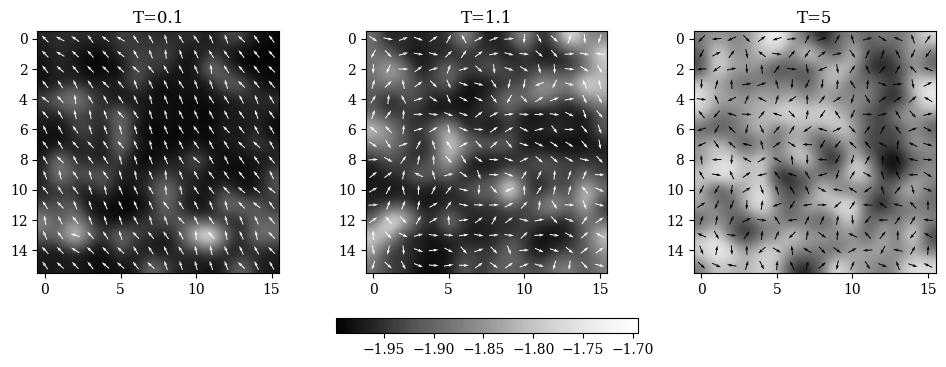

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4))
ax[0].quiver(np.cos(spin_lat1), np.sin(spin_lat1), pivot='mid', scale=25, width=0.004, color='white')
im = ax[0].imshow(E_per_spin(spin_lat1), cmap='Greys_r', interpolation = 'bicubic')
ax[0].set_title("T=0.1")
ax[1].quiver(np.cos(spin_lat2), np.sin(spin_lat2), pivot='mid', scale=25, width=0.004, color='white')
ax[1].imshow(E_per_spin(spin_lat2), cmap='Greys_r', interpolation = 'bicubic')
ax[1].set_title("T=1.1")
ax[2].quiver(np.cos(spin_lat3), np.sin(spin_lat3), pivot='mid', scale=25, width=0.004, color='k')
ax[2].imshow(E_per_spin(spin_lat3), cmap='Greys_r', interpolation = 'bicubic')
ax[2].set_title("T=5")
fig.colorbar(im, ax =ax, orientation='horizontal', fraction=.05)
plt.show()

Below the spin lattice, we plot interpolated energy map of the system. This gives a sense of the energy in different parts of the lattice. In the plots above, lighter areas correspond to higher energy and darker areas correspond to lower energy.

In the low temperature system, the spins are ordered, and most point in the same direction. In the intermdiate temperature system, the system forms domains- regions of order where the spins are aligned, but in a different direction compared to neighbouring domains. In the high temperature region, the spins are highly random, and there is no pattern or alignment.

# Energy, Magnetization, Specific heat and Susceptibility

To plot the above quantities, either run the following cell, or the cell after that.

In [ ]:
# Run this cell in order to generate new data for energy and magnetization, or if the pre-saved txt file is unavailable.
# This cell takes approx. 40 minutes to run with numba

%%time
a = np.linspace(0.1, 0.8, 15); b = np.linspace(0.81, 1.3, 35); c = np.linspace(1.31, 2.5, 15)
T_range = np.concatenate((a,b,c))     # Defining the temperature range, with a higher concentration of points near the critical temperature.
avg_E = np.zeros_like(T_range)        # Initialize arrays for E, E^2, M, M^2, C_v and Chi
avg_E_sqr = np.zeros_like(T_range)
avg_M = np.zeros_like(T_range)
avg_M_sqr = np.zeros_like(T_range)
C_v = np.zeros_like(T_range)
chi = np.zeros_like(T_range)

for i in range(len(T_range)):
    L = 50     # Same lattice size for each run.
    initial, spin_lat, E, M = mc_run(L=L, J=1, T=T_range[i], N_runs=40_000)    # Run 40_000 Monte-Carlo sweeps at each temperature for equilibration and averaging.
    avg_E[i] = np.mean(E[-30_000:])        # Averges are calculated ignoring the first 10_000 sweeps, assuming it takes that many to reach equilibrium.
    avg_E_sqr[i] = np.mean(E[-30_000:]**2)
    m = np.sqrt(M[:,0]**2 + M[:,1]**2)
    avg_M[i] = np.mean(m[-30_000:])
    avg_M_sqr[i] = np.mean(m[-30_000:]**2)

C_v = (avg_E_sqr - avg_E**2)/(T_range**2)      # Calculate specific heat at each temperature
chi = (avg_M_sqr - avg_M**2)/(T_range)         # Calculate susceptibility at each temperature

CPU times: user 34min 24s, sys: 12.9 s, total: 34min 36s
Wall time: 35min 1s


In [10]:
A = np.loadtxt('./Supplementary_InvestigatingtheKTTransition_KeerthanaSudarshan_EshaSajjanhar_SM2023/avgs_30_000_mcsweeps_set2.txt', delimiter=',')     # uncomment this line to load the array of already run values.
a = np.linspace(0.1, 0.8, 15); b = np.linspace(0.81, 1.3, 35); c = np.linspace(1.31, 2.5, 15)
T_range = np.concatenate((a,b,c))
avg_E = A[0]
avg_E_sqr = A[1]
avg_M = A[2]
avg_M_sqr = A[3]
C_v = A[4]
chi = A[5]
L = 50

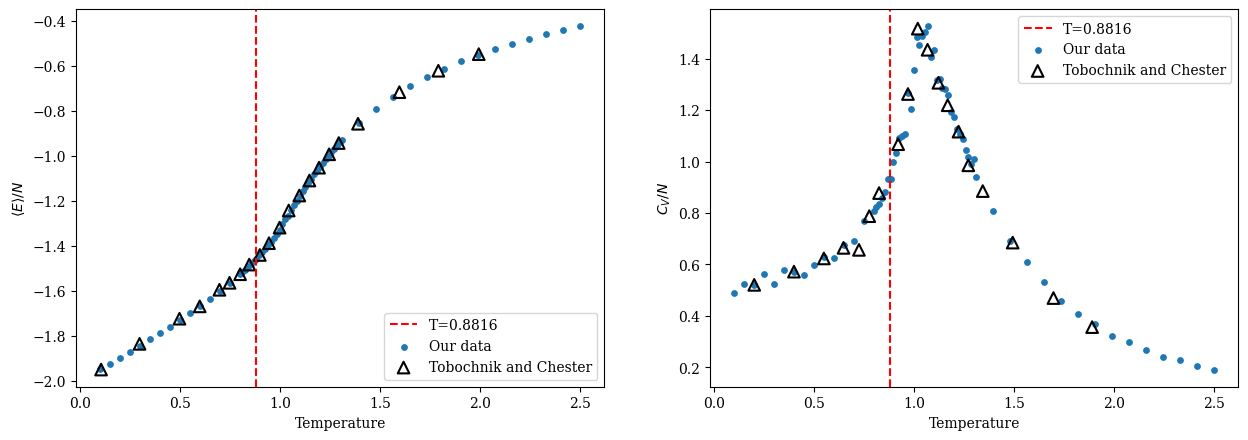

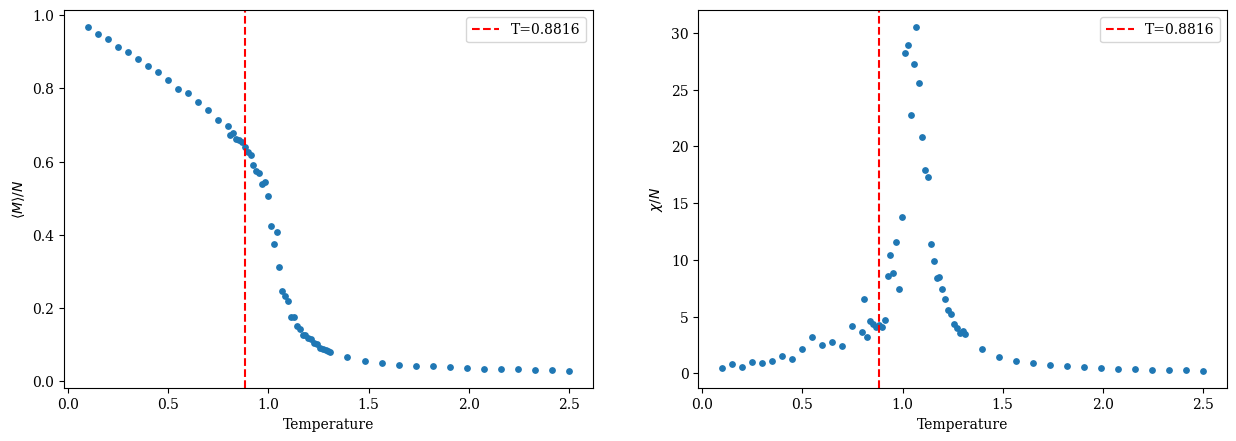

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))    # Setting up subplots figure

TE, E = np.loadtxt('./Supplementary_InvestigatingtheKTTransition_KeerthanaSudarshan_EshaSajjanhar_SM2023/energy_temp_tobochnik.csv', delimiter=',', unpack=True)    # Getting the paper data for energy and Cv
TC, C = np.loadtxt('./Supplementary_InvestigatingtheKTTransition_KeerthanaSudarshan_EshaSajjanhar_SM2023/Cv_temp_tobochnik.csv', delimiter=',', unpack=True)

ax[0].scatter(T_range, avg_E/L/L, s=15, label="Our data")
ax[0].scatter(TE, E, s=70, color='k', marker="^", label='Tobochnik and Chester', facecolor='none', lw=1.5)
ax[0].set_xlabel("Temperature")
ax[0].set_ylabel(r"$\langle E \rangle / N$")
ax[0].axvline(x=0.8816, color='red', ls='--', label="T=0.8816")
ax[0].legend()

ax[1].scatter(T_range, C_v/L/L, s=15, label="Our data")
ax[1].scatter(TC, C, s=70, color='k', marker="^", label='Tobochnik and Chester', facecolor='none', lw=1.5)
ax[1].set_xlabel("Temperature")
ax[1].set_ylabel("$C_V / N$")
ax[1].axvline(x=0.8816, color='red', ls='--', label="T=0.8816")
ax[1].legend()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].scatter(T_range, avg_M/L/L, s=15)
ax[0].set_xlabel("Temperature")
ax[0].set_ylabel(r"$\langle M \rangle / N$")
ax[0].axvline(x=0.8816, color='red', ls='--', label="T=0.8816")
ax[0].legend()

ax[1].scatter(T_range, chi/L/L, s=15)
ax[1].set_xlabel("Temperature")
ax[1].set_ylabel(r"$\chi/N$")
ax[1].axvline(x=0.8816, color='red', ls='--', label="T=0.8816")
ax[1].legend()
plt.show()

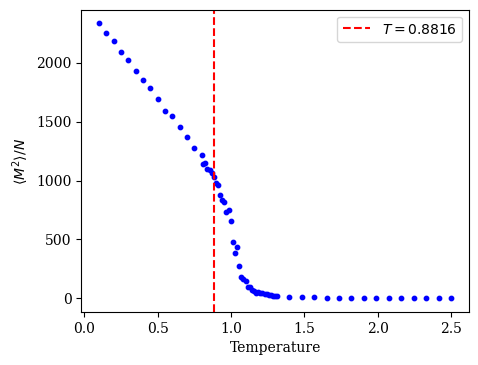

In [12]:
plt.figure(figsize=(5,4))
plt.scatter(T_range, avg_M_sqr/L/L, s=10, color='blue')
plt.axvline(x=0.8816, color='red', ls='--', label='$T = 0.8816$')
plt.xlabel("Temperature")
plt.ylabel(r"$\langle M^2 \rangle / N$")
plt.legend()
plt.show()

### Finding the critical exponents

Assuming a critical temperature of 0.8816, we find the critical exponents in the form $$\chi = e^{b/t^\nu}$$ where $t$ is the reduced temperature $(T-T_c)/T_c$

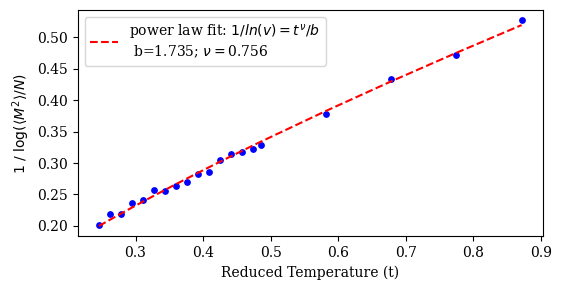

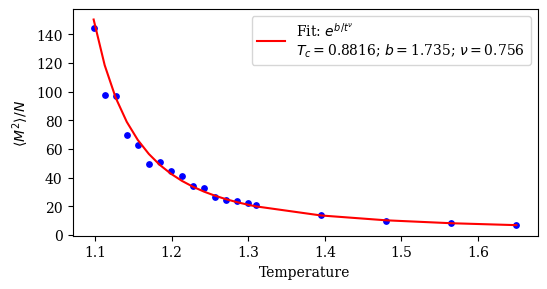

In [13]:
T_c = 0.8816
lo =35; hi = 55
t =(T_range[lo:hi] - T_c)/T_c

plt.figure(figsize=(6,3))
plt.scatter(t, 1/np.log(avg_M_sqr[lo:hi]/L**2), s=15, color='blue')    # log chi vs t graph to get a power law graph
def power(t, nu, b):
    return t**(nu) / b

popt, cov = curve_fit(power, t, 1/np.log(avg_M_sqr[lo:hi]/L**2))     # Scipy curve fit to find the exponent of the power law
b = popt[1]; nu = popt[0]
fit = power(t, nu, b)
plt.plot(t, fit, color='red', ls='--', label=r'power law fit: $1/ln(v) = t^{\nu}/b$'+'\n b='+str(round(b,3))+r'; $\nu=$'+str(round(nu,3)))    # Checking the fit
plt.xlabel('Reduced Temperature (t)')
plt.ylabel(r'$1\ /\ \log(\langle M^2 \rangle / N)$')
plt.legend()
plt.show()

plt.figure(figsize=(6,3))
plt.scatter(T_range[lo:hi], avg_M_sqr[lo:hi]/L**2, s=15, color='blue')      # Plotting the original exponential with the fit to check if it matches
plt.xlabel("Temperature")
plt.ylabel(r"$\langle M^2 \rangle / N$")
fit = np.exp(b/t**nu)
plt.plot(T_range[lo:hi], fit, color='red', label=r'Fit: $e^{b/t^{\nu}}$'+'\n'+r'$T_c =$'+str(T_c)+r'; $b=$'+str(round(b,3))+r'; $\nu=$'+str(round(nu,3)))
plt.legend()
plt.show()

# Vortex identification

First, we simply want to check if the code for identifying vortices performs correctly. In the cell below, we equilibrate the system at some temperature of choice and then check if vortices are present. If they are, we plot them on the system.

1 vortices,  1 antivortices


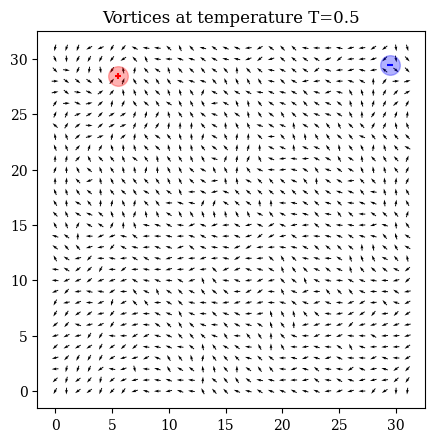

In [14]:
L=32
T=0.5
initial_spins, final_spins, E, M = mc_run(L=L, T=T, N_runs=1_000)

v, av, nv, nav = id_vortex(final_spins)
plt.figure(figsize=(5,5))
plt.quiver(np.cos(final_spins), np.sin(final_spins), pivot='mid')

if (nav+nv)!=0:
    plt.scatter(v[:,0], v[:,1], color='red', marker='+', s=20)
    plt.scatter(v[:,0], v[:,1], color='red', s=12800/L/2, alpha=0.3)
    plt.scatter(av[:,0], av[:,1], color='blue', marker='_', s=20)
    plt.scatter(av[:,0], av[:,1], color='blue', s=12800/L/2, alpha=0.3)
    plt.title("Vortices at temperature T="+str(T))
    print(nv, "vortices, ", nav, "antivortices")

if (nv+nav)==0:
    print('No vortices found.')

# Temperature quench

In order to get vortices at low temperatures, we do what is known as a temperature quench- start off at a high temperature and then rapidly lower it.

In [21]:
%%time
eq = 10_000    # No. of Monte-Carlo steps for equilibration

T_max = 2.5    # Setting high initial temperature
T_min = 0.7    # Setting low final temperature

L = 40         # Set size of lattice
spin_lat_0 = np.zeros((L,L))      # Create initial lattice

# Initially equilibrating at t=T_max
final_spins, E, M, V, V_f = mc_run_alt(spin_lat_0, J=1, T=T_max, N_runs=eq)
spin_lat = np.copy(final_spins)

# Dropping temp to T_min, equilibrating there
final_spins_2, E, M, V, V_f = mc_run_alt(spin_lat, J=1, T=T_min, N_runs=eq)

CPU times: user 12.8 s, sys: 92.9 ms, total: 12.9 s
Wall time: 12.8 s


0 vortices,  0 antivortices


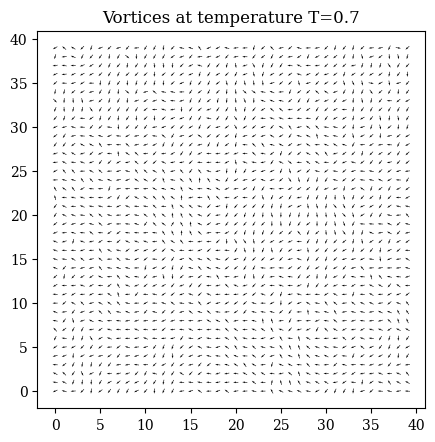

In [22]:
v, av, nv, nav = id_vortex(final_spins_2)
plt.figure(figsize=(5,5))
plt.quiver(np.cos(final_spins_2), np.sin(final_spins_2), pivot='mid', scale=75, width=0.0015)   # Plot the spin system
plt.scatter(v[:,0], v[:,1], color='red', marker='+', s=20)    # Plot the vortices
plt.scatter(v[:,0], v[:,1], color='red', s=12800/L/2, alpha=0.3)
plt.scatter(av[:,0], av[:,1], color='blue', marker='_', s=20)    # Plot the antivortices
plt.scatter(av[:,0], av[:,1], color='blue', s=12800/L/2, alpha=0.3)
plt.title("Vortices at temperature T="+str(T_min))
print(nv, "vortices, ", nav, "antivortices")

In [ ]:
# We can also animate the system from this point to ensure that the remaining vortices behave like true vortices, and do not disappear trivially.

%matplotlib notebook
animate(spins=final_spins_2, T=0.4)

# Vorticity and temperature

Next, we want to look at the variation in the number of vortices at different temperatures. We look at two quantities- the vorticity, which the number of vortices and antivortices per spin; and the number of free vortices per spin, which is the number of vortices without any antivortices to pair with (or vice versa)

In [23]:
%%time
L = 32      # Setting size of the array
T_range = np.linspace(0.1,2.5,21)    # Setting range of temperatures we want to look at
equil = 1_000
avg = 6_000

spin_lat = np.zeros((L, L))       # Creating the initial array
avg_V = np.zeros_like(T_range)
avg_Vf = np.zeros_like(T_range)

for i in tqdm(range(len(T_range))):
    spin_lat, E, M, V, V_f = mc_run_alt(spin_lat, J=1, T=T_range[i], N_runs=equil+avg)     # Getting the vorticity and free vorticity from the alternate Monte-Carlo function at different temperatures.
    avg_V[i] = np.mean(V[-avg:])       # Taking the average, neglecting the first 1_000 runs
    avg_Vf[i] = np.mean(V_f[-avg:])

100%|███████████████████████████████████████████| 21/21 [01:01<00:00,  2.94s/it]

CPU times: user 1min, sys: 478 ms, total: 1min
Wall time: 1min 1s


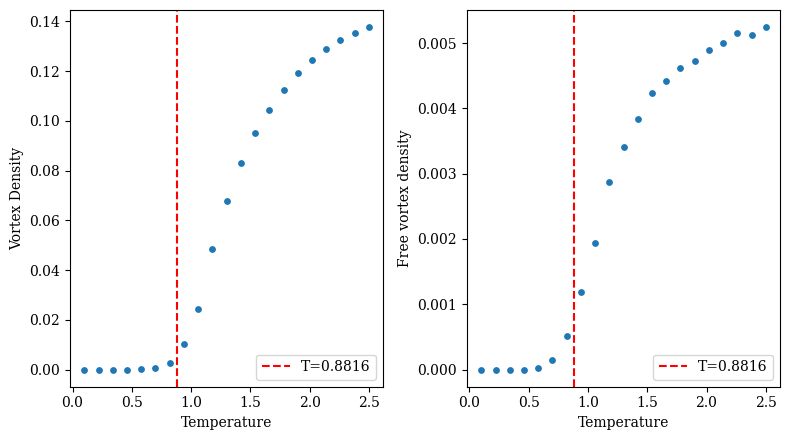

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4.5))

T_range = np.linspace(0.1,2.5,21)
ax[0].scatter(T_range, avg_V/L/L, s=15)
ax[0].set_xlabel("Temperature")
ax[0].set_ylabel("Vortex Density")
ax[0].axvline(x=0.8816, color='red', ls='--', label="T=0.8816")
ax[0].legend()

ax[1].scatter(T_range, avg_Vf/L/L, s=15)
ax[1].set_xlabel("Temperature")
ax[1].set_ylabel("Free vortex density")
ax[1].axvline(x=0.8816, color='red', ls='--', label="T=0.8816")
ax[1].legend()

plt.tight_layout()
plt.show()

Now, we want to look more closely at the exponential growth part of the vorticity graph, to see what the behaviour is near the critical temperature and below. To do this, we plot the log of the vorticity versus $\beta$, as we expect it to behave as $v \sim e^{-2\mu/T}$

In [25]:
%%time
L = 60
beta_range =  np.linspace(0.4, 1.4, 15)
T_range = 1/beta_range
equil = 1_000
avg = 6_000

spin_lat = np.zeros((L, L))
avg_V = np.zeros_like(T_range)
avg_Vf = np.zeros_like(T_range)

for i in tqdm(range(len(T_range))):
    spin_lat, E, M, V, V_f = mc_run_alt(spin_lat, J=1, T=T_range[i], N_runs=equil+avg)
    avg_V[i] = np.mean(V[-avg:])
    avg_Vf[i] = np.mean(V_f[-avg:])

100%|███████████████████████████████████████████| 15/15 [02:29<00:00,  9.99s/it]

CPU times: user 2min 26s, sys: 1.35 s, total: 2min 27s
Wall time: 2min 29s


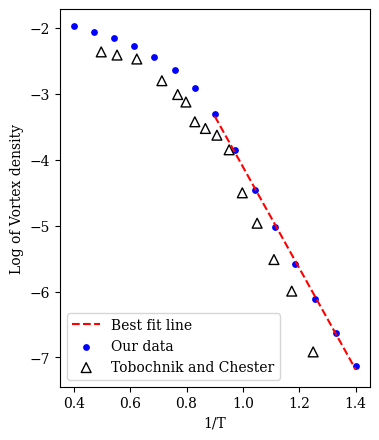

Energy required to create a pair of vortices= 7.68479398538045


In [27]:
plt.figure(figsize=(4,5))
beta = 1/T_range
log_v = np.log(avg_V/L/L)

plt.scatter(beta_range, log_v, s=15, color='blue', label='Our data')
a,b = np.polyfit(beta[7:], log_v[7:], 1)
fit = [a*x + b for x in beta[7:]]
plt.plot(beta[7:], fit, color='red', ls='--', label='Best fit line')
plt.ylabel('Log of Vortex density')
plt.xlabel('1/T')

beta, ln_v = np.loadtxt('./Supplementary_InvestigatingtheKTTransition_KeerthanaSudarshan_EshaSajjanhar_SM2023/tobochnik_vorticity_data.csv', delimiter=',', unpack=True)
plt.scatter(beta, ln_v, s=50, color='k', marker="^", label='Tobochnik and Chester', facecolor='none', lw=1)

plt.legend()
plt.show()
twomu = -a
print('Energy required to create a pair of vortices=', twomu)

Finally, we can observe the evolution of a randomly generated set of spins at various temperatures, and observe the formation/annihilation of vortex-antivortex pairs.

In [ ]:
%matplotlib notebook
L = 16
spin_lat_0 = np.ones((L, L))
for i in range(L):
    for j in range(L):
        spin_lat_0[i][j] *= np.random.uniform(0,1)*2*np.pi

animate(spin_lat_0, T=0.4, h=0, step=1, save_animation=False, save_name='equilibration.mp4', save_dpi=300, save_fps=50)

# Correlation function

There are two algorithms that can be followed for calculating the correlation function. The first is what we followed, wherein the function is calculated by going over every possible pair on the lattice. The second the algorithm followed by Tobochnik and Gould, wherein the function is calculated by pairing each spin with the first spin.

#### Algorithm no. 1:

In [32]:
def exp_fit(x, a, b, c):
    '''Function used to fit exponential curve to the correlation function.'''
    return a*np.exp(-x/b) + c

@njit
def pbc_distance(rij, L):
    '''
    Get the correct distance between two particles, accounting for periodic boundary conditions.

    Parameters:
    -----------
    • rij : A numpy array of 2 elements storing the `x` and `y` values of the separation `rij`.

    Returns:
    --------
    The function returns one value:
    • rij : The corrected r_ij, including the effects of periodic boundary conditions.
    '''

    #input rij is the separation between the particles calculated without boundary conditions

    #checking if the separation rij violates the boundary conditions
    #and evaluating the true distance whenever this is the case

    if abs(rij[0]) > 0.5*L:
        rij[0] = rij[0] - L*(rij[0]/abs(rij[0]))
    if abs(rij[1]) > 0.5*L:
        rij[1] = rij[1] - L*(rij[1]/abs(rij[1]))

    return rij

@njit
def get_correlation(spins, mag_per_spin, bins=10):
    ''' Gives the spin-spin correlation function for a given spin lattice.

    Parameters:
    -----------
    • spins        : A 2D array of the spin lattice for which the correlation function is to be calculated.
    • mag_per_spin : Average magnetization per spin for the input spin lattice.
    • bins         : Number of distance bins (values of r) used to calculate the correlation (C(r)), this is set to 10 by default.

    Returns:
    --------
    • cr/nr        : An array of length `bins` containing the value of the spin-spin correlation for each distance bin.
    • r            : An array containing the distance bins for which correlation has been calculated.
    '''

    #obtaining the dimensions of the lattice
    L = np.shape(spins)[0]

    #defining the distance bins using the input for number of bins
    r = np.linspace(1, L/np.sqrt(2), bins)

    #empty array to store the number of spins which fit into any one distance bin
    nr = np.zeros_like(r)

    #empty array to store sum of the correlation values for each bin before calculating the mean
    Cr = np.zeros_like(r)
    dx = L/np.sqrt(2)/bins

    #looping over all pairs of spins in the lattice
    #the first spin is indexed by [i,j] and the second spin is indexed by [p,q]
    for i in range(L):
        for j in range(L):
            for p in range(L):
                for q in range(L):

                    #continuing the loop only for pairs of distinct spins
                    if i != p or j != q:
                        #defining the difference between the 'coordinates' of the spin
                        x = p-i
                        y = q-j
                        #storing these in an array and finding the distance using periodic boundary conditions
                        rij = pbc_distance(np.array([x,y]), L)
                        dist = np.sqrt(rij[0]**2 + rij[1]**2)
                        #computing the correlation for this pair of spins
                        corr =  np.cos(spins[i][j]-spins[p][q])-mag_per_spin**2

                        #assigning this correlation to a distance bin
                        rbin = int(dist/dx)
                        nr[rbin] += 1
                        Cr[rbin] += corr

    #setting zero elements to 1 in order to prevent `nan` values in the output
    nr[nr<1] = 1

    #returning the average value of c(r) for each bin and the distance bins
    return Cr/nr, r

@njit
def corr_avg(spins, energy, T,J=1, sweeps=10_000, bins=10):
    ''' Gives the spin-spin correlation function averaged over many runs for a given spin lattice.
    The correlation is calculated after every 100 Monte-Carlo sweeps and its value is averaged across all runs to find the correlation.

    Parameters:
    -----------
    • spins        : A 2D array of the spin lattice for which the correlation function is to be calculated.
    • energy       : Total energy for the input spin lattice.
    • T            : Temperature at which this spin system is evolved.
    • J            : Parameter giving the strength of spin-spin interactions, set to 1 by default.
    • sweeps       : The number of Monte-Carlo sweeps over which to evolve the function while calculating correlation.
    • bins         : Number of distance bins (values of r) used to calculate the correlation (C(r)), this is set to 10 by default.


    Returns:
    --------
    • correlations : An array of length `bins` containing the value of the spin-spin correlation for each distance bin.
    • r            : An array containing the distance bins for which correlation has been calculated.
    '''

    #defining an empty array to store value of correlation
    cr = np.ones((sweeps//100, bins))
    L = np.shape(spins)[0]                              #defining the shape of the lattice
    N = L**2                                            #number of spins in the lattice

    #looping over all monte carlo sweeps
    for mc in range(sweeps):

      #allowing the system to 'heat up' over 10_000 Monte-Carlo sweeps
        spins, energy = mc_sweep(spins, energy, L, J, T=T)

        #evaluating the correlation function every 100 steos
        if mc%100==0:
          #calculating average magnetization per spin for the lattice
            m = np.sqrt(np.sum(np.cos(spins))**2 + np.sum(np.sin(spins))**2)/N
            #evaluating the correlation for the given pair of spins
            cr[mc//100], bins_array = get_correlation(spins, m, bins=bins)

    #defining an empty array to store the values of correlation
    correlation = np.ones(bins)

    #looping over all distance bins
    for i in range(bins):
      #storing the correlation for each bin averaged across all monte-carlo sweeps
        correlation[i] = np.mean(cr[:, i])

    #returning the averaged correlations and associated distance bins
    return correlation, bins_array

In [33]:
%%time

#finding correlation length at different temperatures
L = 60
N = L**2
T1 = 0.7
T2 = 1.3
_, spin_fin1, E1, _ = mc_run(L=L, J=1, T=T1, N_runs = 10_000)
cr07, bins07 = corr_avg(spin_fin1, E1, T1, bins=10)
_, spin_fin2, E2, _ = mc_run(L=L, J=1, T=T2, N_runs = 10_000)
cr13, bins13 = corr_avg(spin_fin2, E2, T2, bins=10)

CPU times: user 6min 21s, sys: 2.93 s, total: 6min 24s
Wall time: 6min 27s


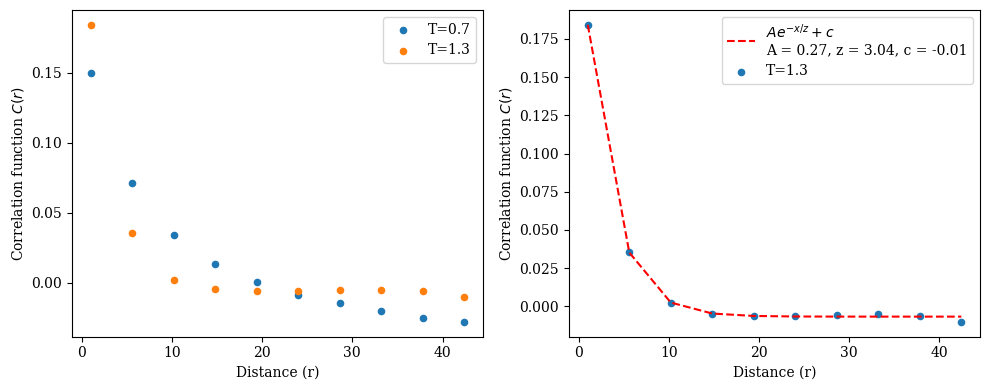

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

#fitting an exponential
popt2, _ = curve_fit(exp_fit, bins13, cr13)

ax[0].scatter(bins07, cr07, s=20, label='T=0.7')
ax[0].scatter(bins13, cr13, s=20, label='T=1.3')
ax[0].set_xlabel('Distance (r)')
ax[0].set_ylabel(r'Correlation function $C(r)$')
ax[0].legend()

ax[1].scatter(bins13, cr13, s=20, label='T=1.3')
ax[1].plot(bins13, exp_fit(bins13, *popt2), color='r', ls='--', label='$Ae^{-x/z} + c$ \n' + 'A = ' + str(np.round(popt2[0], 2)) + ', z = ' + str(np.round(popt2[1], 2)) + ', c = ' + str(np.round(popt2[2], 2)))
ax[1].set_xlabel('Distance (r)')
ax[1].set_ylabel(r'Correlation function $C(r)$')
ax[1].legend()

plt.tight_layout()

In [ ]:
%%time
#TAKES 40 MINUTES TO RUN.

temp_range = np.linspace(0.88*1.000001, 1.4, 8)
zeta = np.zeros_like(temp_range)
L = 60
N = L**2
for i in tqdm(range(len(temp_range))):
    _, spin_fin, E, _ = mc_run(L=L, J=1, T=temp_range[i], N_runs = 10_000)
    cr, bins = corr_avg(spin_fin, E, temp_range[i], bins=10)
    popt, _ = curve_fit(exp_fit, bins, cr)
    zeta[i] = popt[1]

In [ ]:
plt.scatter(temp_range, zeta)
plt.xlabel('Temperature')
plt.ylabel(r'Correlation length $\xi$')
plt.show()

#### Algorithm no. 2:

In [ ]:
def exp_fit(x, a, b, c):
    return a*np.exp(-x/b) + c

@njit
def pbc_distance(rij, L):

    if abs(rij[0]) > 0.5*L:
        rij[0] = rij[0] - L*(rij[0]/abs(rij[0]))
    if abs(rij[1]) > 0.5*L:
        rij[1] = rij[1] - L*(rij[1]/abs(rij[1]))

    return rij

@njit
def get_correlation(spins, bins=15):
    ''' This function takes in a spin lattice configuration and the average magnetization per spin for the lattice.
It also has the parameter `bins` which controls the number of bins for which values of C(r) are calculated. This is set
to 20 by default.
If the number of bins chosen is too large, the function will return `nan` for some distance bins. The function returns
an error whenever this is the case.
'''

    #obtaining the dimensions of the lattice
    L = np.shape(spins)[0]

    #defining the distance bins using the input for number of bins
    r = np.linspace(1, L/np.sqrt(2), bins)

    #empty array to store the number of spins which fit into any one distance bin
    nr = np.zeros_like(r)

    #empty array to store sum of the correlation values for each bin before calculating the mean
    Cr = np.zeros_like(r)
    dx = L/np.sqrt(2)/bins

    #looping over all pairs of spins in the lattice
    #the first spin is indexed by [i,j] and the second spin is indexed by [p,q]
    for i in range(L):
        for j in range(L):
            for p in [0]:
                for q in [0]:

                    #continuing the loop only for pairs of distinct spins
                    if i != p or j != q:
                        #defining the difference between the 'coordinates' of the spin
                        x = p-i
                        y = q-j
                        #storing these in an array and finding the distance using periodic boundary conditions
                        rij = pbc_distance(np.array([x,y]), L)
                        dist = np.sqrt(rij[0]**2 + rij[1]**2)
                        #computing the correlation for this pair of spins
                        corr =  np.cos(spins[i][j]-spins[p][q])

                        rbin = int(dist/dx)
                        nr[rbin] += 1
                        Cr[rbin] += corr
    nr[nr<1] = 1
    #returning the average value of c(r) for each bin and the distance bins
    return Cr/nr, r

@njit
def corr_avg(spins, energy, temp,J=1, sweeps=10_000, bins=15):
    cr = np.ones((sweeps//100, bins))
    L = np.shape(spins)[0]
    N = L**2
    for mc in range(sweeps):
        spins, energy = mc_sweep(spins, energy, L, J, T=temp)
        if mc%100==0:
            cr[mc//100], bins_array = get_correlation(spins, bins=bins)
    correlation = np.ones(bins)
    for i in range(bins):
        correlation[i] = np.mean(cr[:, i])
    return correlation, bins_array


In [ ]:
%%time

#finding correlation length at different temperatures
L = 60
N = L**2
T1 = 0.7
T2 = 1.3
_, spin_fin1, E1, _ = mc_run(L=L, J=1, T=T1, N_runs = 10_000)
cr07, bins07 = corr_avg(spin_fin1, E1, T1, bins=15)
_, spin_fin2, E2, _ = mc_run(L=L, J=1, T=T2, N_runs = 10_000)
cr13, bins13 = corr_avg(spin_fin2, E2, T2, bins=15)

In [ ]:
#fitting exponential
popt1, _ = curve_fit(exp_fit, bins07, cr07)
popt2, _ = curve_fit(exp_fit, bins13, cr13)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

#fitting an exponential
popt2, _ = curve_fit(exp_fit, bins13, cr13)

ax[0].scatter(bins07, cr07, s=20, label='T=0.7')
ax[0].scatter(bins13, cr13, s=20, label='T=1.3')
ax[0].set_xlabel('Distance (r)')
ax[0].set_ylabel(r'Correlation function $C(r)$')
ax[0].legend()

ax[1].scatter(bins13, cr13, s=20, label='T=1.3')
ax[1].plot(bins13, exp_fit(bins13, *popt2), color='r', ls='--', label='$Ae^{-x/z} + c$ \n' + 'A = ' + str(np.round(popt2[0], 2)) + ', z = ' + str(np.round(popt2[1], 2)) + ', c = ' + str(np.round(popt2[2], 2)))
ax[1].set_xlabel('Distance (r)')
ax[1].set_ylabel(r'Correlation function $C(r)$')
ax[1].legend()

plt.tight_layout()

In [ ]:
%%time
#TAKES 40 MINUTES TO RUN.

temp_range = np.linspace(0.88*1.000001, 1.4, 8)
zeta = np.zeros_like(temp_range)
L = 60
N = L**2
for i in tqdm(range(len(temp_range))):
    _, spin_fin, E, _ = mc_run(L=L, J=1, T=temp_range[i], N_runs = 10_000)
    cr, bins = corr_avg(spin_fin, E, temp_range[i], bins=10)
    popt, _ = curve_fit(exp_fit, bins, cr)
    zeta[i] = popt[1]

In [ ]:
plt.scatter(temp_range, zeta)
plt.xlabel('Temperature')
plt.ylabel(r'Correlation length $\xi$')
plt.show()